In [15]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm 
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**TIME SERIES ANALYSIS**

In [3]:
df_prices = pd.read_csv('/content/drive/MyDrive/Copy of SESN.csv')
print(df_prices.head())
print(df_prices.size)

         Date   Open   High   Low  Close  Adj Close   Volume
0  2021-11-18  1.132  1.140  1.02   1.03       1.03  7831100
1  2021-11-19  1.020  1.140  1.01   1.07       1.07  5582400
2  2021-11-22  1.070  1.120  1.05   1.07       1.07  4479200
3  2021-11-23  1.070  1.090  1.03   1.05       1.05  3715300
4  2021-11-24  1.060  1.117  1.04   1.09       1.09  3163400
1771


# New Section

In [4]:
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       253 non-null    datetime64[ns]
 1   Open       253 non-null    float64       
 2   High       253 non-null    float64       
 3   Low        253 non-null    float64       
 4   Close      253 non-null    float64       
 5   Adj Close  253 non-null    float64       
 6   Volume     253 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 14.0 KB


In [5]:
df_prices.dropna(inplace = True)


Text(0, 0.5, 'Close')

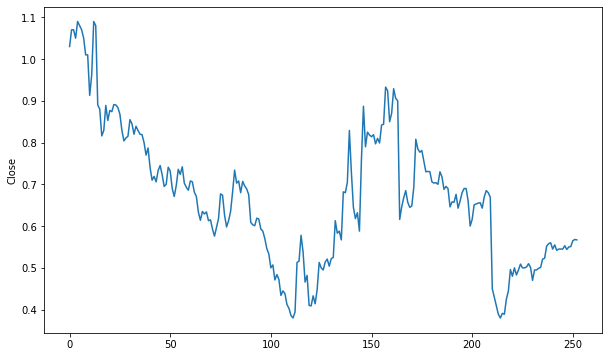

In [6]:
plt.figure(figsize=(10, 6))
df_prices['Close'].plot()
plt.ylabel('Close')

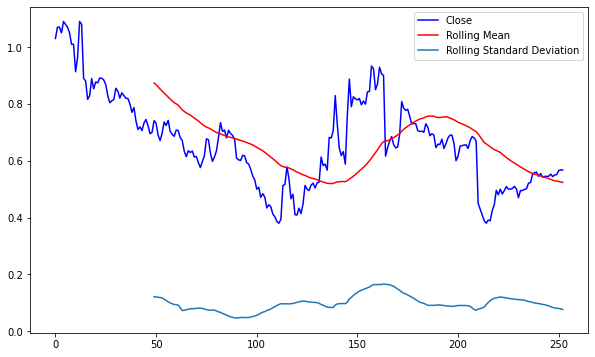

In [7]:
close = df_prices['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df_prices['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns')

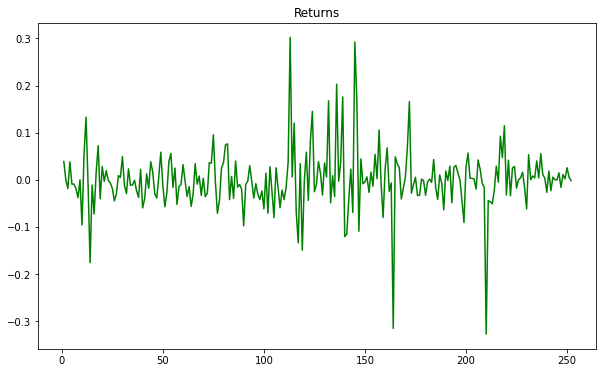

In [8]:
returns = close/close.shift(1) - 1
plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [9]:
train = df_prices[:1000]
test = df_prices[1000:]

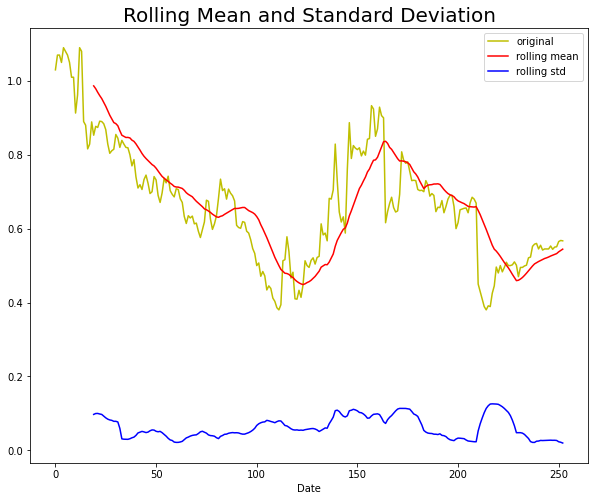

Results of dickey fuller test
ADF Test Statistic : -2.7357997180113816
p-value : 0.0680455684546924
#Lags Used : 0
Number of Observations Used : 252
Weak evidence against null hypothesis, time series is non-stationary 


In [10]:
def test_stationarity(timeseries):

 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])


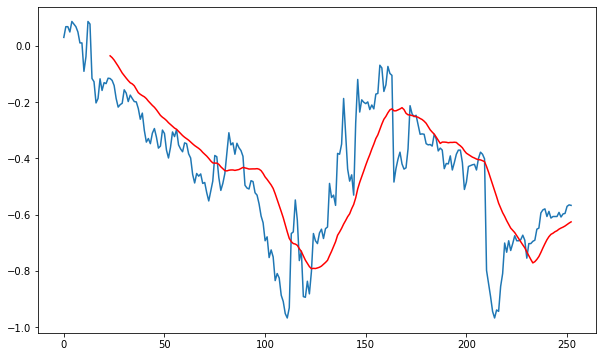

In [11]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])
mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red') 

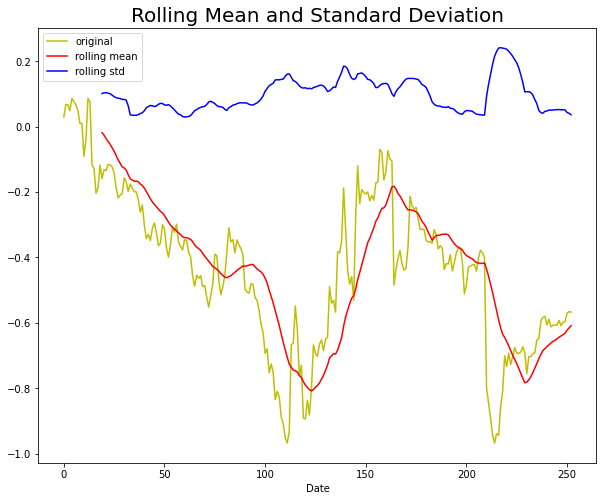

Results of dickey fuller test
ADF Test Statistic : -2.554690137191685
p-value : 0.10272807639930903
#Lags Used : 0
Number of Observations Used : 252
Weak evidence against null hypothesis, time series is non-stationary 


In [12]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)
test_stationarity(train_log)

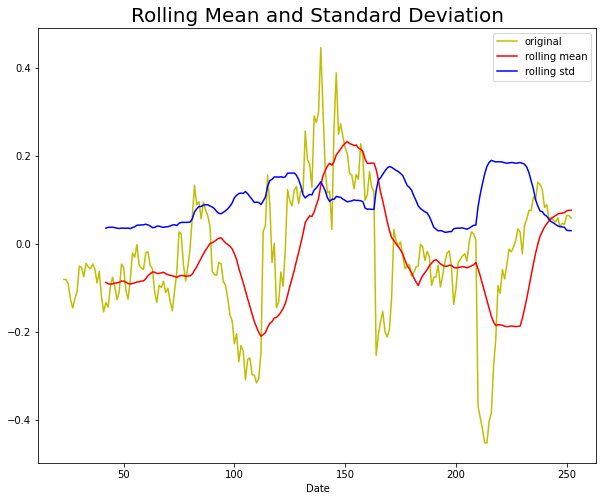

Results of dickey fuller test
ADF Test Statistic : -3.3142707676928485
p-value : 0.014252497963939905
#Lags Used : 0
Number of Observations Used : 229
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [13]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)
test_stationarity(train_log_diff)

In [19]:
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions=''
try:
  predictions = model.predict(n_periods = len(test))
except:
  print()
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-654.131, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-658.639, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-656.829, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-656.839, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-660.304, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-655.160, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.917 seconds



Text(0, 0.5, 'Actual Stock Price')

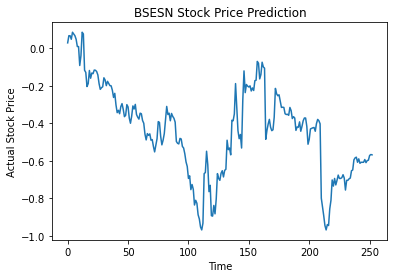

In [20]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

In [25]:
cols = ['Date','Category','News']
df_news = pd.read_csv('/content/drive/MyDrive/india-news-headlines.csv', names = cols)
df_news

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
3650966,20220331,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3650967,20220331,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650968,20220331,city.trichy,As Covid-19 cases drop to nil in southern dist...
3650969,20220331,city.erode,Tamil Nadu sees marginal rise of Covid cases w...


In [26]:
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3650970 entries, 1 to 3650970
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    object
 1   News    object
dtypes: object(2)
memory usage: 83.6+ MB


In [27]:
 df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
 df_news

,Date,News
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,Fissures in Hurriyat over Pak visit
3,2001-01-02,America's unwanted heading for India?
4,2001-01-02,For bigwigs; it is destination Goa
5,2001-01-02,Extra buses to clear tourist traffic
...,...,...
3650966,2022-03-31,J&K sacks 2 cops; 3 other employees over terro...
3650967,2022-03-31,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650968,2022-03-31,As Covid-19 cases drop to nil in southern dist...
3650969,2022-03-31,Tamil Nadu sees marginal rise of Covid cases w...


In [28]:
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...
7713,2022-03-28,As fashion becomes democratic; demand for styl...
7714,2022-03-29,Bobby Deol: Like my dad; I hope to be working ...
7715,2022-03-30,I will not give in to trends: Dossmode The tim...


In [29]:
df_news['News']

0       Status quo will not be disturbed at Ayodhya; s...
1       Powerless north India gropes in the dark Think...
2       The string that pulled Stephen Hawking to Indi...
3       Light combat craft takes India into club class...
4       Light combat craft takes India into club class...
                              ...                        
7712    Playing a dead man in Body God meant sitting i...
7713    As fashion becomes democratic; demand for styl...
7714    Bobby Deol: Like my dad; I hope to be working ...
7715    I will not give in to trends: Dossmode The tim...
7716    Shashank goes back to coastal Karnataka and Mo...
Name: News, Length: 7717, dtype: object

In [31]:
c = []
for i in range(0,len(df_news['News'])):
    news = re.sub('[^a-zA-Z]',' ',df_news['News'][i])
    news = news.lower()
    news = news.split()
    try:
      news = [ps.stem(word) for word in news if not word in set(stopwords.words('english'))]
    except:
      news=' '.join(news)
      
    c.append(news)

In [32]:
df_news['News'] = pd.Series(c)
df_news

,Date,News
0,2001-01-02,status quo will not be disturbed at ayodhya sa...
1,2001-01-03,powerless north india gropes in the dark think...
2,2001-01-04,the string that pulled stephen hawking to indi...
3,2001-01-05,light combat craft takes india into club class...
4,2001-01-06,light combat craft takes india into club class...
...,...,...
7712,2022-03-27,playing a dead man in body god meant sitting i...
7713,2022-03-28,as fashion becomes democratic demand for styli...
7714,2022-03-29,bobby deol like my dad i hope to be working wh...
7715,2022-03-30,i will not give in to trends dossmode the time...


In [33]:
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [38]:
try:
  df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
except:
  print()
try:
  df_news['Polarity'] = df_news['News'].apply(getPolarity)
except:
  print()
df_news

,Date,News,Subjectivity,Polarity
0,2001-01-02,status quo will not be disturbed at ayodhya sa...,0.286859,0.143590
1,2001-01-03,powerless north india gropes in the dark think...,0.392857,0.089286
2,2001-01-04,the string that pulled stephen hawking to indi...,0.445360,0.093039
3,2001-01-05,light combat craft takes india into club class...,0.480553,0.264024
4,2001-01-06,light combat craft takes india into club class...,0.439394,0.248485
...,...,...,...,...
7712,2022-03-27,playing a dead man in body god meant sitting i...,0.365123,0.034162
7713,2022-03-28,as fashion becomes democratic demand for styli...,0.383007,0.058513
7714,2022-03-29,bobby deol like my dad i hope to be working wh...,0.403627,0.092144
7715,2022-03-30,i will not give in to trends dossmode the time...,0.344136,0.039954


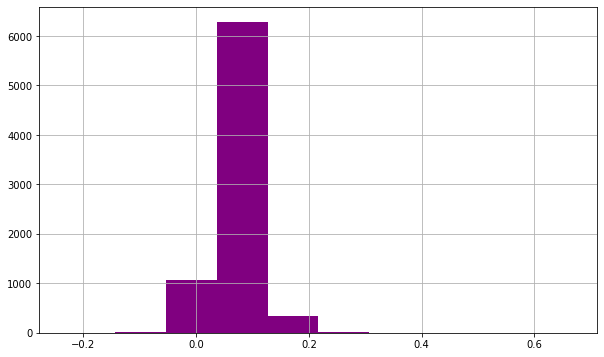

In [39]:
plt.figure(figsize = (10,6))
df_news['Polarity'].hist(color = 'purple')

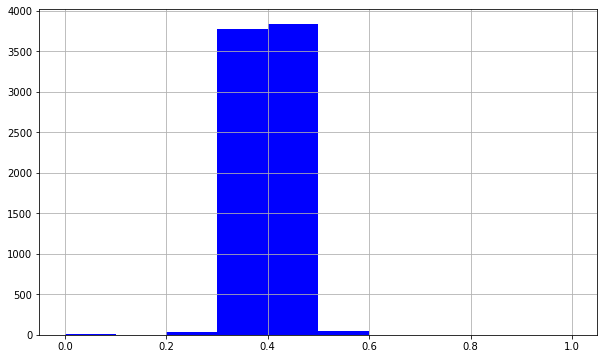

In [41]:
plt.figure(figsize = (10,6))
df_news['Subjectivity'].hist(color = 'blue')

In [43]:
df_merge = pd.merge(df_prices, df_news, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity
0,2021-11-18,1.132,1.140,1.02,1.030,1.030,7831100,horoscope today november check astrological pr...,0.377890,0.055330
1,2021-11-19,1.020,1.140,1.01,1.070,1.070,5582400,horoscope today november check astrological pr...,0.381010,0.063611
2,2021-11-22,1.070,1.120,1.05,1.070,1.070,4479200,horoscope today november check astrological pr...,0.363697,0.075070
3,2021-11-23,1.070,1.090,1.03,1.050,1.050,3715300,power outage leaves residents of kondhwa undri...,0.352724,0.046314
4,2021-11-24,1.060,1.117,1.04,1.090,1.090,3163400,horoscope today november check astrological pr...,0.358954,0.063513
...,...,...,...,...,...,...,...,...,...,...
87,2022-03-25,0.708,0.710,0.67,0.696,0.696,1880700,speeding up shortcuts and tackling unruly cust...,0.373221,-0.003922
88,2022-03-28,0.720,0.720,0.66,0.689,0.689,2243100,as fashion becomes democratic demand for styli...,0.383007,0.058513
89,2022-03-29,0.690,0.695,0.66,0.675,0.675,2023200,bobby deol like my dad i hope to be working wh...,0.403627,0.092144
90,2022-03-30,0.650,0.660,0.60,0.609,0.609,6319700,i will not give in to trends dossmode the time...,0.344136,0.039954


In [48]:
df = df_merge[['Close','Subjectivity', 'Polarity']]
df

,Close,Subjectivity,Polarity
0,1.030,0.377890,0.055330
1,1.070,0.381010,0.063611
2,1.070,0.363697,0.075070
3,1.050,0.352724,0.046314
4,1.090,0.358954,0.063513
...,...,...,...
87,0.696,0.373221,-0.003922
88,0.689,0.383007,0.058513
89,0.675,0.403627,0.092144
90,0.609,0.344136,0.039954


In [49]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(df))
new_df.columns = df.columns
new_df.index = df.index
new_df.head()

,Close,Subjectivity,Polarity
0,0.883268,0.582482,0.547315
1,0.961089,0.616448,0.623799
2,0.961089,0.428018,0.729648
3,0.922179,0.308589,0.464033
4,1.000000,0.376401,0.622895


In [50]:
X = new_df.drop('Close', axis=1)
y =new_df['Close']

In [51]:
X.head()

,Subjectivity,Polarity
0,0.582482,0.547315
1,0.616448,0.623799
2,0.428018,0.729648
3,0.308589,0.464033
4,0.376401,0.622895


In [52]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(73, 2)

In [53]:
x_train[:10]

,Subjectivity,Polarity
30,0.784636,0.749550
41,0.366768,0.452054
54,0.642853,0.727545
6,0.873725,0.934477
43,0.231828,0.437750
77,0.620192,0.697989
74,0.609873,0.534418
56,0.216941,0.311676
75,0.823978,0.599072
81,0.592468,0.593673


In [54]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [55]:
print(prediction[:10])
print(y_test[:10])
print(mean_squared_error(prediction,y_test))

[0.18649805 0.28484436 0.27338521 0.23029183 0.30756809 0.38394942
 0.33885214 0.34793774 0.70177043 0.39143969]
2     0.961089
33    0.511673
22    0.612840
16    0.466926
13    0.980545
24    0.599222
60    0.256809
76    0.190661
80    0.114786
68    0.112840
Name: Close, dtype: float64
0.12004162479849488


In [56]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)

In [57]:
print(mean_squared_error(predictions, y_test))

0.10661991154643434


In [58]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree.fit(x_train, y_train)
predictions = dec_tree.predict(x_test)

In [59]:
print(predictions[:10])
print(y_test[:10])
print(mean_squared_error(predictions,y_test))

[0.07587549 0.44357977 0.10311284 0.11478599 0.07392996 0.19649805
 0.47276265 0.08171206 0.96108949 0.21984436]
2     0.961089
33    0.511673
22    0.612840
16    0.466926
13    0.980545
24    0.599222
60    0.256809
76    0.190661
80    0.114786
68    0.112840
Name: Close, dtype: float64
0.20708827816031314


In [60]:
lgb = lightgbm.LGBMRegressor()
lgb.fit(x_train, y_train)

LGBMRegressor()

In [61]:
predictions = lgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.09795663880101127


In [62]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

[13:57:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [63]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.1313124337420213
